In [5]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from scipy.stats import skew,norm

%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook


In [6]:
#read data
train = pd.read_csv("G:Machine learning\\kaggel\\house prices\\train.csv")
test = pd.read_csv("G:Machine learning\\kaggel\\house prices\\test.csv")


In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

In [9]:
all_data.shape


(2919, 79)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000A812FCB828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000A81905AE80>]], dtype=object)

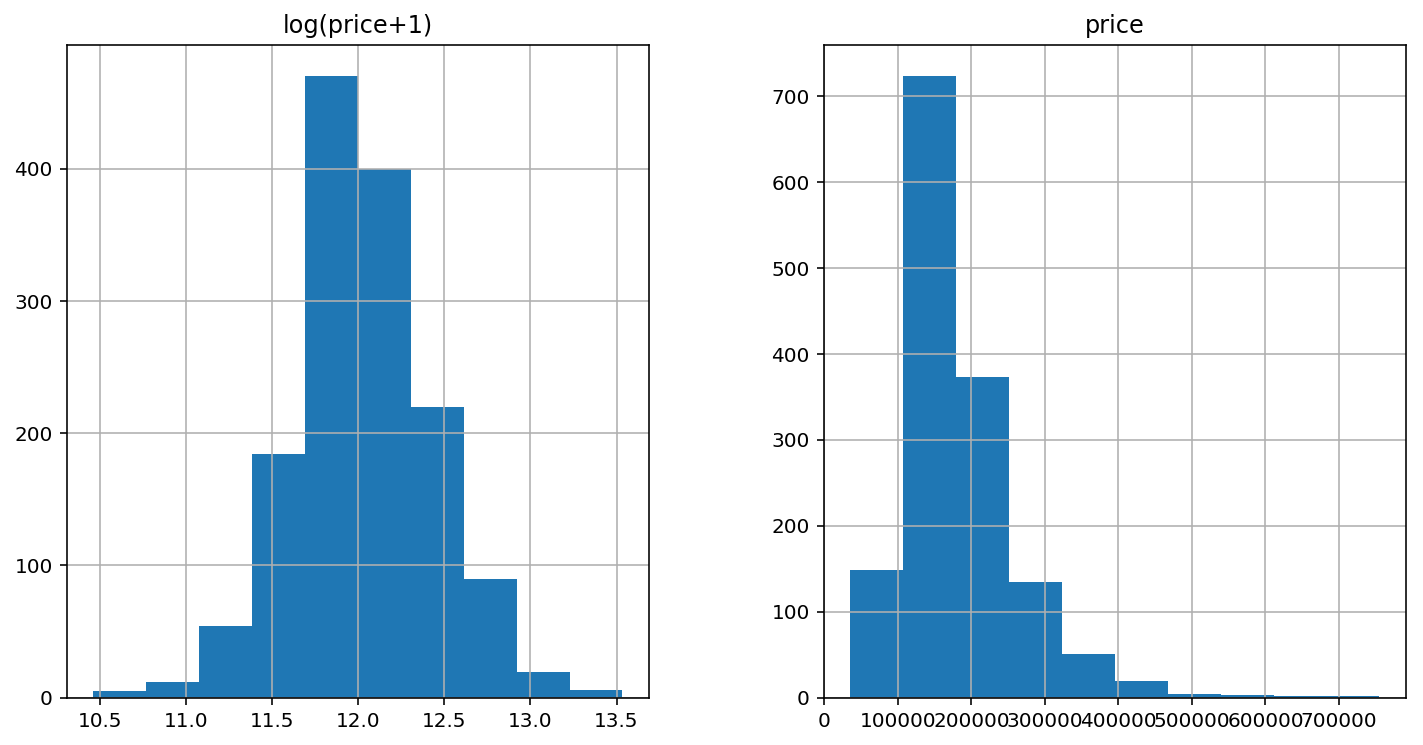

In [10]:
#matplotlib rcParams配置绘图参数 
matplotlib.rcParams['figure.figsize'] = (12.0,6.0)
prices = pd.DataFrame({"price": train['SalePrice'],"log(price+1)" : np.log1p(train['SalePrice'])})
prices.hist() #直方图

In [11]:
#log transform
train['SalePrice'] = np.log1p(train['SalePrice'])
#log transform skewd  numeric features 
#numeric_features = 
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
#skew 计算skewness (斜度) dropna()去除含有空值的列，返回非空列
skewd_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewd_feats = skewd_feats[skewd_feats > 0.75].index
all_data[skewd_feats] = np.log1p(all_data[skewd_feats])

In [12]:
all_data = pd.get_dummies(all_data)

In [13]:
#filling NA's with the mean of columns
all_data = all_data.fillna(all_data.mean())

In [14]:
#creating matices for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice


In [15]:
#models  
#https://baijiahao.baidu.com/s?id=1571894231493139&wfr=spider&for=pc  四种模型的讲解
from sklearn.linear_model import Ridge,RidgeCV,LassoCV,LassoLarsCV,ElasticNet
from sklearn.model_selection import cross_val_score #交叉验证

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring = "neg_mean_squared_error", cv = 5))
    return (rmse)


In [16]:
model_ridge = Ridge()


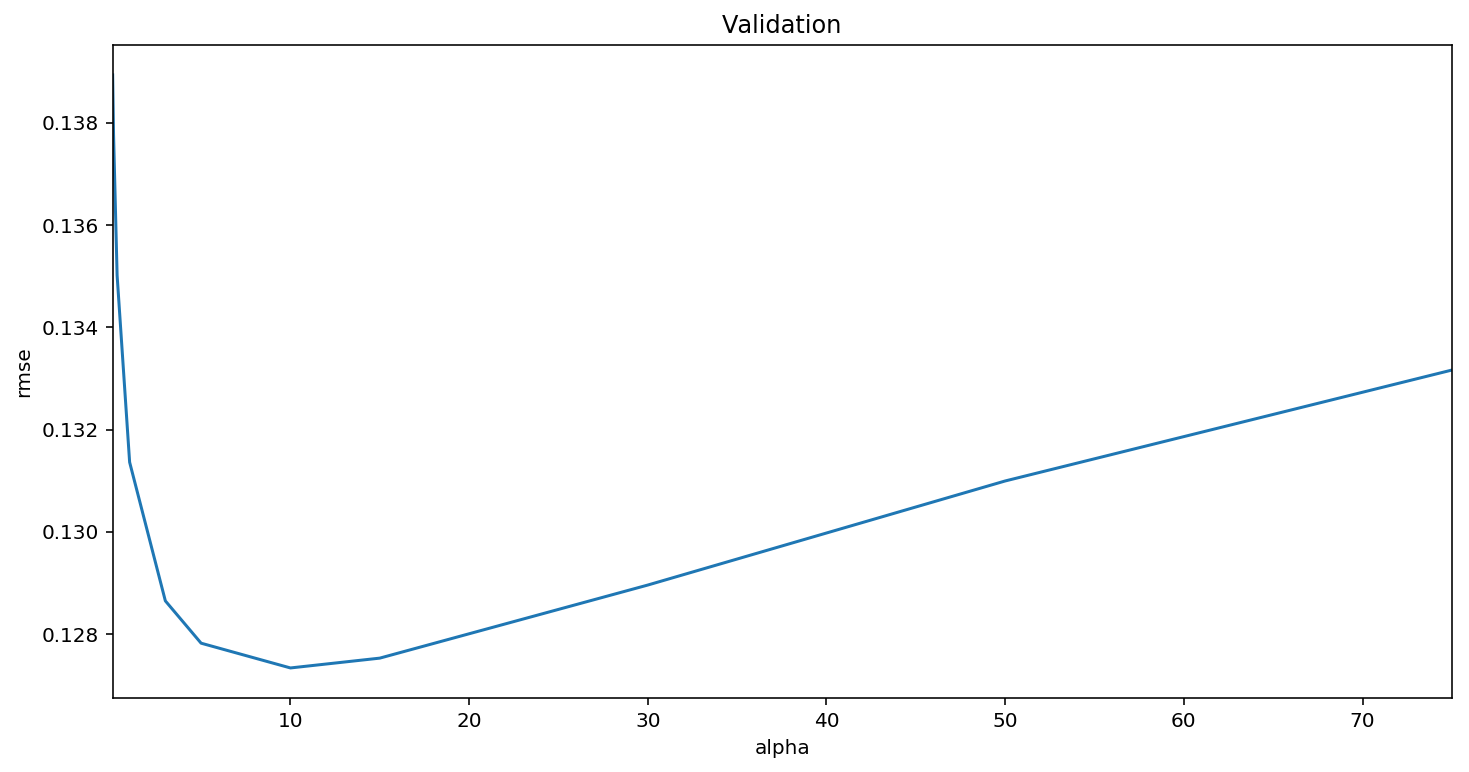

In [17]:
#Ridge回归交叉验证
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv ( Ridge ( alpha = alpha ) ).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge,index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel ("alpha")
plt.ylabel( "rmse" )

In [18]:
cv_ridge.min()

0.12733734668670754

In [19]:
#lasso回归 交叉验证
model_lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.0005]).fit(X_train,y)
cv_lasso = rmse_cv (model_lasso).mean()
cv_lasso

#比Ridge的差错要小  所以选择LassoCV进行test数据的测试

0.12256735885048127

In [20]:
#Lasso可以自动选择特征量--- 筛选他认为不重要的特征系数设为0
coef = pd.Series(model_lasso.coef_,index = X_train.columns)

print("Lasso picked "+ str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0))+ " variables")

Lasso picked 110 variables and eliminated the other 178 variables


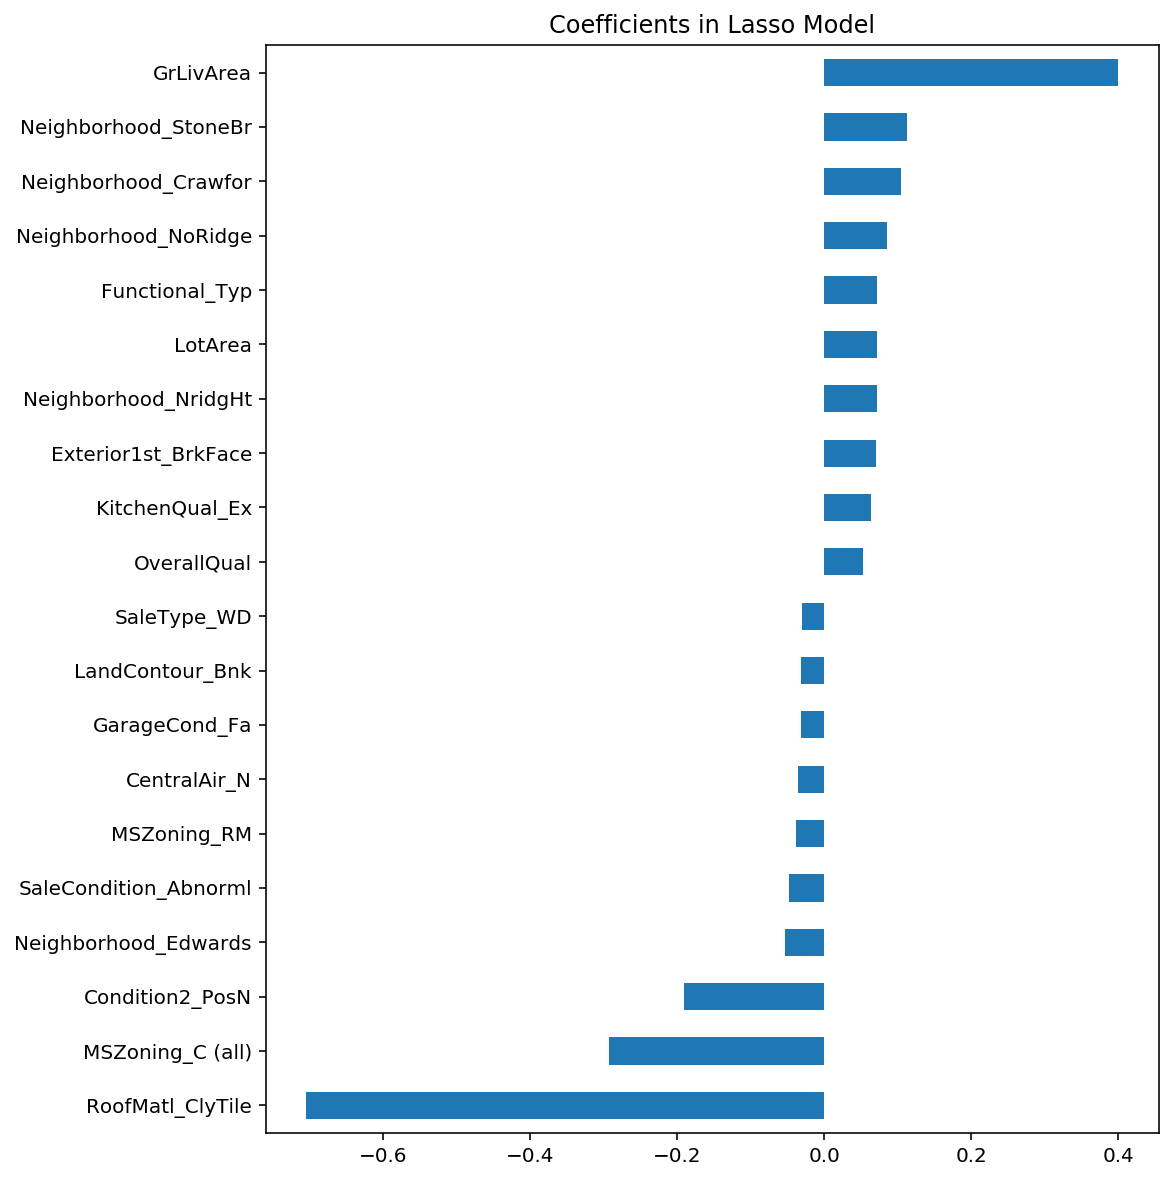

In [21]:
#important coefficients
impo_coef = pd.concat([coef.sort_values().head(10),coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0,10.0)
impo_coef.plot(kind = "barh")#水平柱状图 
plt.title("Coefficients in Lasso Model")

# 可以看出 GrLiArea 相关性最大

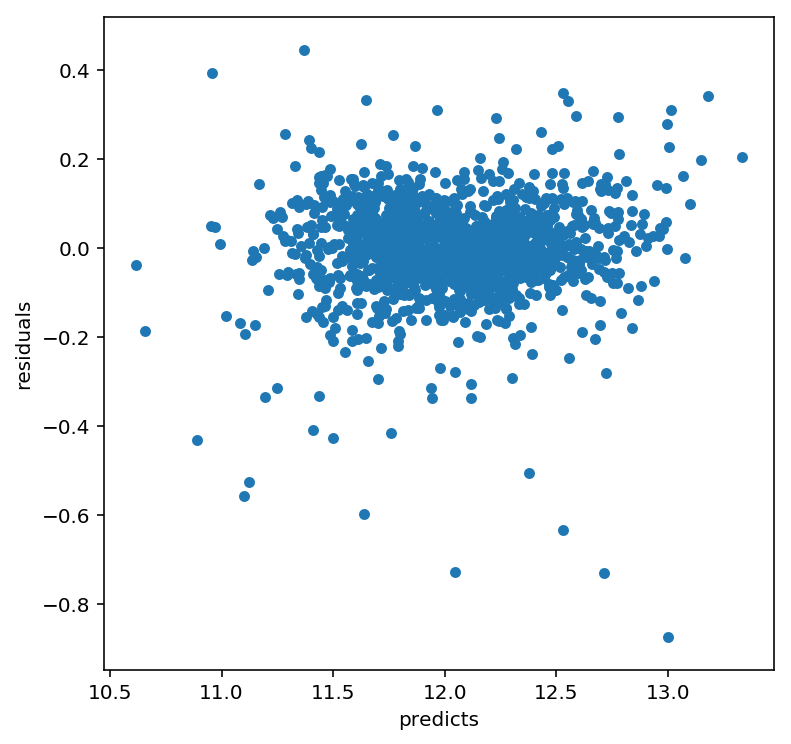

In [22]:
#look at residuals  残差
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

pred_df = pd.DataFrame({"true": y,"predicts" :model_lasso.predict(X_train)})
pred_df.columns

pred_df['residuals'] = pred_df['true']-pred_df['predicts']
pred_df.plot(x = "predicts" , y = "residuals" , kind = "scatter")

In [23]:
# test
print("generating test files")
test_predict = model_lasso.predict(X_test)
submission = pd.DataFrame({"Id" : test["Id"], "SalePrice" : np.exp(test_predict)})  #本来是log  要进行exp转换
submission.to_csv("G:Machine learning\\kaggel\\house prices\\house_price_submission.csv",index = False)

generating test files


In [ ]:
# xgboost
import xgboost as xgb
dtrain = xgb.DMatrix(X_train,label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth" : 2 ,"eta ": 0.1}
model = xgb.cv(params,dtrain,num_boost_round = 500, early_stopping_rounds = 100)


In [ ]:
model.loc[30:,["test-rmse-mean","train-rmse-mean"]].plot(xlim = (0,500),ylim = (0,0.15))

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.exp(model_xgb.predict(X_test))
lasso_preds = np.exp(model_lasso.predict(X_test))
lasso_preds

In [ ]:
predictions = pd.DataFrame({"xgb" : xgb_preds,"lasso" : lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")


In [ ]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds
preds

In [ ]:
solution = pd.DataFrame({"id" : test["Id"],"SalePrice" : preds})
solution.to_csv("G:Machine learning\\kaggel\\house prices\\house_price_xgboost_submission.csv",index = False)


In [34]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [35]:
X_train = StandardScaler().fit_transform(X_train)
